In [1]:
%matplotlib inline

import math
import os
import shutil
from collections import defaultdict

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook

In [2]:
qpath = ['quads/train/' + s for s in os.listdir('quads/train/')]
mpath = ['quads/truth/' + s for s in os.listdir('quads/truth/')]
tpath = ['../data/testing/images/' + s for s in os.listdir('../data/testing/images/')]

In [3]:
quads = [cv2.imread(p) for p in qpath]
masks = [cv2.imread(p) for p in mpath]
tests = [cv2.imread(p) for p in tpath]

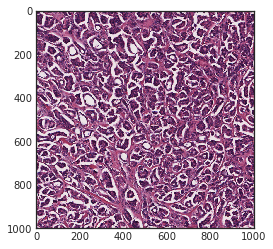

In [4]:
plt.imshow(quads[0][:, :, ::-1])
plt.show()

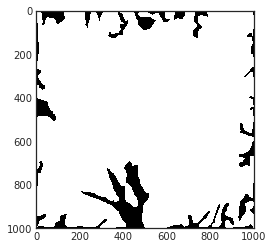

In [5]:
plt.imshow(masks[0][:, :, ::-1])
plt.show()

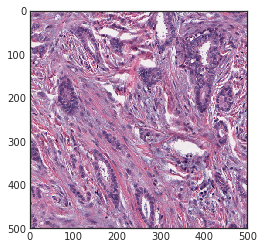

In [6]:
plt.imshow(tests[0][:, :, ::-1])
plt.show()

In [7]:
def area(a, b, c):
    def distance(p1, p2):
        return math.hypot(p1[0]-p2[0], p1[1]-p2[1])

    side_a = distance(a, b)
    side_b = distance(b, c)
    side_c = distance(c, a)
    s = 0.5 * ( side_a + side_b + side_c)
    return math.sqrt(s * (s - side_a) * (s - side_b) * (s - side_c))


def match(test, quad, display=False):
    surf = cv2.xfeatures2d.SURF_create()
    bf = cv2.BFMatcher()

    test = cv2.cvtColor(test.copy(), cv2.COLOR_BGR2GRAY)
    quad = cv2.cvtColor(quad.copy(), cv2.COLOR_BGR2GRAY)

    tkp, tdes = surf.detectAndCompute(test, None)
    qkp, qdes = surf.detectAndCompute(quad, None)

    matches = bf.knnMatch(tdes, qdes, k=2)

    mindist = 999.0
    good = []
    for m, n in matches:
        if m.distance / n.distance < mindist:
                mindist = m.distance / n.distance
        if m.distance < 0.4 * n.distance:
            good.append([m])
    dists = np.array([g[0].distance for g in good])
    print(f'{len(good)}: {mindist}')

    if display:
        img = cv2.drawMatchesKnn(test, tkp, quad, qkp, good, None, flags=2)
        plt.figure(figsize=(16, 12))
        plt.imshow(img)
        plt.show()

    if good:
        Ms = []

        ratios = []
        for i in range(len(dists) * 4 // 5 - 2):        
            tp = np.array([tkp[g[0].queryIdx].pt for g in good[i:i+3]])
            qp = np.array([qkp[g[0].trainIdx].pt for g in good[i:i+3]])
            ta = area(*tp)
            qa = area(*qp)
            ratio = max(ta, qa) / max(min(ta, qa), 1e-6)
            if ratio < 1.02:
                ratios.append(ratio)
                Ms.append(cv2.getAffineTransform(tp.astype(np.float32), qp.astype(np.float32)))
        print(len(ratios))

        if len(Ms) == 1:
            M = Ms
        else:
            M = np.mean(Ms, axis=0)

        if np.all(np.isfinite(M)):
            return M
        else:
            print(ratios)
            print('WHATHASHAPPEND', Ms)
    else:
        return None

In [8]:
pairs = pd.read_csv('pairs.txt', dtype='str')

In [18]:
shutil.rmtree('cheated', ignore_errors=True)
os.makedirs('cheated')

for i, (quad, test) in enumerate(zip(tqdm_notebook(pairs['quad']), pairs['test'])):
    qp = list(filter(lambda s: s.find(quad) != -1, qpath))[0]
    tp = list(filter(lambda s: s.find(test) != -1, tpath))[0]
    mp = list(filter(lambda s: s.find(quad) != -1, mpath))[0]
    mask = cv2.imread(mp)
    quad = cv2.imread(qp)
    test = cv2.imread(tp)

    flipped = False
    M = match(test, quad)
    if M is None:
        test = np.flipud(test)
        flipped = True
        M = match(test, quad)
        if M is None:
            print(tp, qp)
            plt.figure(figsize=(12, 4))
            plt.subplot(131), plt.imshow(test[:, :, ::-1])
            plt.subplot(133), plt.imshow(quad[:, :, ::-1])
            plt.show()
            raise ValueError('FAILED')
    R = cv2.invertAffineTransform(M)

    indx = np.zeros_like(test)
    indx[:500, :500] = 255

    # aftest = cv2.warpAffine(test, M, quad.shape[:2], cv2.INTER_CUBIC)
    afindx = cv2.warpAffine(indx, M, quad.shape[:2], cv2.INTER_CUBIC)
    
    print(np.mean(afindx))

    # aftile = np.zeros_like(quad)
    aftrue = np.zeros_like(mask)
    # aftile[afindx > 0] = quad[afindx > 0]
    aftrue[afindx > 127] = mask[afindx > 127]

    true = cv2.warpAffine(aftrue, R, test.shape[:2], cv2.INTER_CUBIC)

    if flipped:
        test = np.flipud(test)
        true = np.flipud(true)

    plt.imsave(f'cheated/{os.path.basename(tp)}_in.png', test[:, :, ::-1])
    plt.imsave(f'cheated/{os.path.basename(tp)}_out.png', true)

    mp = os.path.basename(tp).replace('.tif', '_mask.txt')
    np.savetxt(f'cheated/{mp}', (true[:, :, 0].T / 255 > 0.5).astype(np.uint8), fmt='%d', delimiter='')

#     plt.imsave(f'matched/{i}_affn.png', affn)
#     plt.imsave(f'matched/{i}_quad.png', quad)
    
#     plt.figure(figsize=(15, 10))
#     plt.subplot(231), plt.imshow(test4[:, :, ::-1])
#     plt.subplot(232), plt.imshow(afft[:, :, ::-1])
#     plt.subplot(233), plt.imshow(quad[:, :, ::-1])
#     plt.subplot(234), plt.imshow(mask[:, :, ::-1])
#     plt.subplot(235), plt.imshow(true[:, :, ::-1])
#     plt.subplot(236), plt.imshow(cv2.warpAffine(true, I.astype(np.float32),
#                                  quad.shape[:2])[:, :, ::-1]), cv2.INTER_CUBIC
#     plt.show()
#     plt.imsave('1test.png', test4)
#     plt.imsave('2affn.png', affn)
#     plt.imsave('3quad.png', quad)
    
#     plt.subplot(121)
#     plt.imshow(quad)
#     plt.subplot(122)
#     plt.imshow(test)
#     plt.show()

57: 0.15349005243200492
12
63.617529
69: 0.20971495731862996
26
63.758525
160: 0.12965018159084943
28
64.044073
0: 0.5326895656564185
740: 0.08806248328342944
180
63.546335
79: 0.19681184044631675
29
63.796011
0: 0.5356369086194457
67: 0.1583202243221877
14
63.89161
0: 0.6453683178990566
651: 0.10261185597081995
178
63.509874
97: 0.16895020069290634
14
63.97413
296: 0.10794535228463531
60
63.943012
156: 0.16122505424241035
39
63.642467
0: 0.6773206710701356
87: 0.1788739305009839
24
63.532859
48: 0.13686797187971567
19
63.956775
398: 0.10779265445592807
103
63.804652
545: 0.10414090599147285
105
63.903366
199: 0.16915529869274867
41
63.716966
0: 0.5228154505176553
304: 0.12478739772163532
64
63.85326
0: 0.46296681749516505
76: 0.1460064351358086
13
63.898141
0: 0.49934941468525657
320: 0.1101293999315895
83
63.772819
419: 0.0899526481265641
108
63.73678
0: 0.6930989002889847
97: 0.14475874571328914
15
63.511195
552: 0.1356059164450822
183
63.819291
0: 0.6457850609040895
79: 0.141725106

69
0.20971495731862996


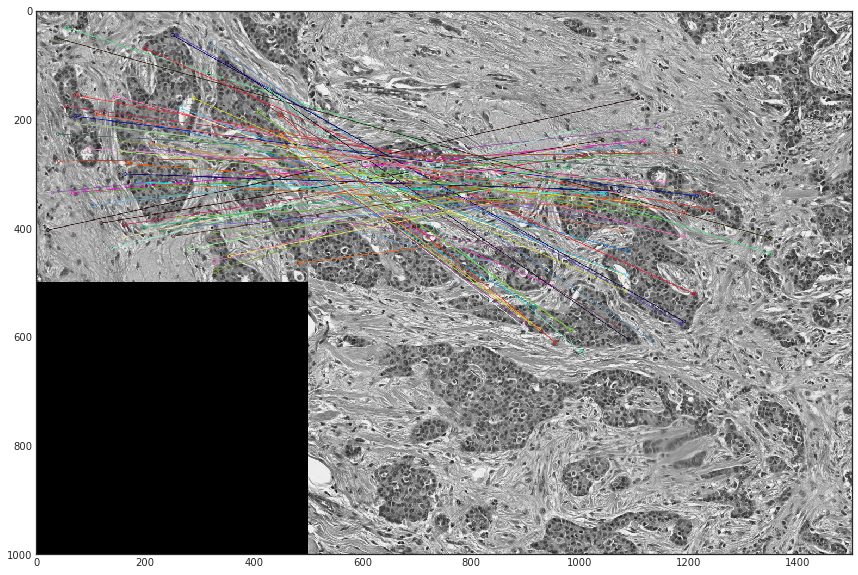

In [37]:
surf = cv2.xfeatures2d.SURF_create()
bf = cv2.BFMatcher()

test = cv2.imread(list(filter(lambda s: s.find(pairs['test'].iloc[1]) != -1, tpath))[0])
quad = cv2.imread(list(filter(lambda s: s.find(pairs['quad'].iloc[1]) != -1, qpath))[0])
mask = cv2.imread(list(filter(lambda s: s.find(pairs['quad'].iloc[1]) != -1, mpath))[0])

gtest = cv2.cvtColor(test.copy(), cv2.COLOR_BGR2GRAY)
gquad = cv2.cvtColor(quad.copy(), cv2.COLOR_BGR2GRAY)

tkp, tdes = surf.detectAndCompute(gtest, None)
qkp, qdes = surf.detectAndCompute(gquad, None)

matches = bf.knnMatch(tdes, qdes, k=2)

mindist = 999.0
good = []
for m, n in matches:
    if m.distance < 0.4 * n.distance:
        if m.distance / n.distance < mindist:
            mindist = m.distance / n.distance
        good.append([m])
print(len(good))
dists = np.array([g[0].distance for g in good])
if good:
    good = list(np.array(good)[np.argsort(dists)])
    print(mindist)

img = cv2.drawMatchesKnn(gtest, tkp, gquad, qkp, good, None, flags=2)
plt.figure(figsize=(16, 10))
plt.imshow(img)
plt.show()

In [26]:
ratios = []
Ms = []
for i in range(len(dists) * 4 // 5 - 2):        
    tp = np.array([tkp[g[0].queryIdx].pt for g in good[i:i+3]])
    qp = np.array([qkp[g[0].trainIdx].pt for g in good[i:i+3]])
    ta = area(*tp)
    qa = area(*qp)
    ratio = max(ta, qa) / max(min(ta, qa), 1e-6)
    if ratio < 1.05:
        ratios.append(ratio)
        Ms.append(cv2.getAffineTransform(tp.astype(np.float32), qp.astype(np.float32)))
print(len(ratios))
M = np.mean(Ms, axis=0)
I = cv2.invertAffineTransform(M)

42


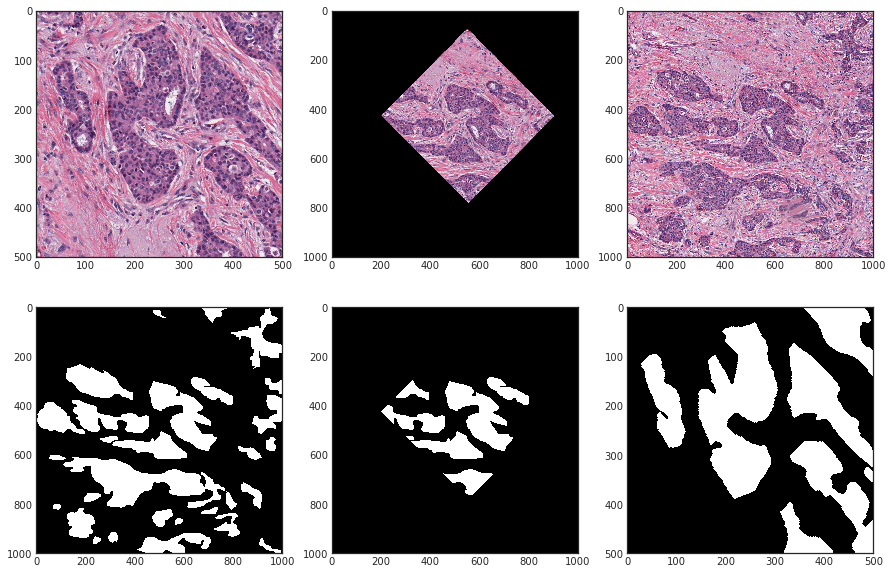

True

In [35]:
cropr = np.zeros_like(test)
cropr[:500, :500] = 255
afft = cv2.warpAffine(test, M, quad.shape[:2], cv2.INTER_CUBIC)
affc = cv2.warpAffine(cropr, M, quad.shape[:2], cv2.INTER_CUBIC)
tile = np.zeros_like(quad)
atrue = np.zeros_like(quad)
true = np.zeros_like(mask)
tile[affc > 127] = quad[affc > 127]
atrue[affc > 127] = mask[affc > 127]
true = 255 * (cv2.warpAffine(atrue, I.astype(np.float32), test.shape[:2], cv2.INTER_CUBIC) > 127).astype(np.uint8)
plt.figure(figsize=(15, 10))
plt.subplot(231), plt.imshow(test[:, :, ::-1])
plt.subplot(232), plt.imshow(afft[:, :, ::-1])
plt.subplot(233), plt.imshow(quad[:, :, ::-1])
plt.subplot(234), plt.imshow(mask[:, :, ::-1])
plt.subplot(235), plt.imshow(atrue[:, :, ::-1])
plt.subplot(236), plt.imshow(true[:, :, ::-1])
plt.show()
cv2.imwrite('0true.png', true)
cv2.imwrite('1test.png', test)
cv2.imwrite('2afft.png', afft)
cv2.imwrite('3quad.png', quad)